In [3]:
import os
import warnings
from pprint import pprint

In [4]:
import descarteslabs as dl

In [5]:
# *************FIND COUNTRY BOUNDARY ***************
matches = dl.places.find('burundi')
aoi = matches[0]
pprint(aoi)

# This area of interest just gives us some basic properties such as bounding boxes.
# To access a GeoJSON Geometry object of that place, we call the `Places.shape` method, in this case
# accessing a low-resolution version of this particular shape.
shape = dl.places.shape(aoi['slug'], geom='low')

{'bbox': [29.001302, -4.468538, 30.849959, -2.309987],
 'id': 85632285,
 'name': 'Burundi',
 'path': 'continent:africa_country:burundi',
 'placetype': 'country',
 'slug': 'africa_burundi'}


In [28]:
# import json

# *************FIND MATCHING SATELLITE IMAGES ***************
# PRODUCTS


# See what satellite products are available 
products = dl.metadata.available_products()
# pprint(products)

# isolate landsat 8 products
landsat_products = []
for product in products:
  if 'LC08'in product: 
    landsat_products.append(product)

# Isolate images from Burundi's dry season, from June to September.
feature_collection = dl.metadata.search(
    products= landsat_products, 
    start_time='2017-06-01',
    end_time='2017-09-30',
    cloud_fraction= .2,
    place=aoi['slug'])

# Through visual inspection, I identified the best images to mosaic from the subset. 

north_east = 'landsat:LC08:01:RT:TOAR:meta_LC08_L1TP_172062_20170701_20170701_01_RT_v1'
south_east = 'landsat:LC08:01:RT:TOAR:meta_LC08_L1TP_172063_20170701_20170701_01_RT_v1'
north_west = 'landsat:LC08:01:T1:TOAR:meta_LC08_L1TP_173062_20170606_20170616_01_T1_v1'
south_west = 'landsat:LC08:01:T1:TOAR:meta_LC08_L1TP_173063_20170606_20170616_01_T1_v1'

ids = [north_east, south_east, north_west, south_west]


In [36]:
# *************OUTPUT ARRAY ***************

# Rasterize the features.
#  * Select red, green, blue, alpha
#  * Scale the incoming data with range [0, 10000] down to [0, 4000] (40% TOAR)
#  * Choose an output type of "Byte" (uint8)
#  * Choose 60m resolution
#  * Apply a cutline of Burundi's boundary 


arr, meta = dl.raster.ndarray(
    ids,
    bands=['red', 'green', 'blue', 'alpha'],
    scales=[[0,4000], [0, 4000], [0, 4000], None],
    data_type='Byte',
    resolution=60,
    cutline=shape['geometry']
)

'''
for id in ids:
    arr, meta = dl.raster.raster(
        id,
        bands=['red', 'green', 'blue', 'alpha'],
        scales=[[0,4000], [0, 4000], [0, 4000], None],
        data_type='Byte',
        resolution=60,
        cutline=shape['geometry'],
        save= "true"
    )
'''

# Note: A value of 1 in the alpha channel signifies where there is valid data.
# We use this throughout the majority of our imagery as a standard way of specifying
# valid or nodata regions. This is particularly helpful if a value of 0 in a particular
# band has meaning, rather than specifying a lack of data.



'\nfor id in ids:\n    arr, meta = dl.raster.raster(\n        id,\n        bands=[\'red\', \'green\', \'blue\', \'alpha\'],\n        scales=[[0,4000], [0, 4000], [0, 4000], None],\n        data_type=\'Byte\',\n        resolution=60,\n        cutline=shape[\'geometry\'],\n        save= "true"\n    )\n'

In [35]:
print(arr.shape)
num_rows = len(arr)
row_center =num_rows/2
print("Number of rows: ", num_rows)
print("Middle row: ", row_center)

num_cols = len(arr[0])
col_center = num_cols/2
print("Number of cols: ", num_cols)
print("Middle col: ", col_center)

middle_value = arr[row_center][col_center]

print("Middle value: ", middle_value)

(3985, 3430, 4)
Number of rows:  3985
Middle row:  1992.5
Number of cols:  3430
Middle col:  1715.0
Middle value:  [ 44  47  56 255]


/Users/karla/anaconda3/envs/poverty-predictor/lib/python3.5/site-packages/ipykernel_launcher.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':
/Users/karla/anaconda3/envs/poverty-predictor/lib/python3.5/site-packages/ipykernel_launcher.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':


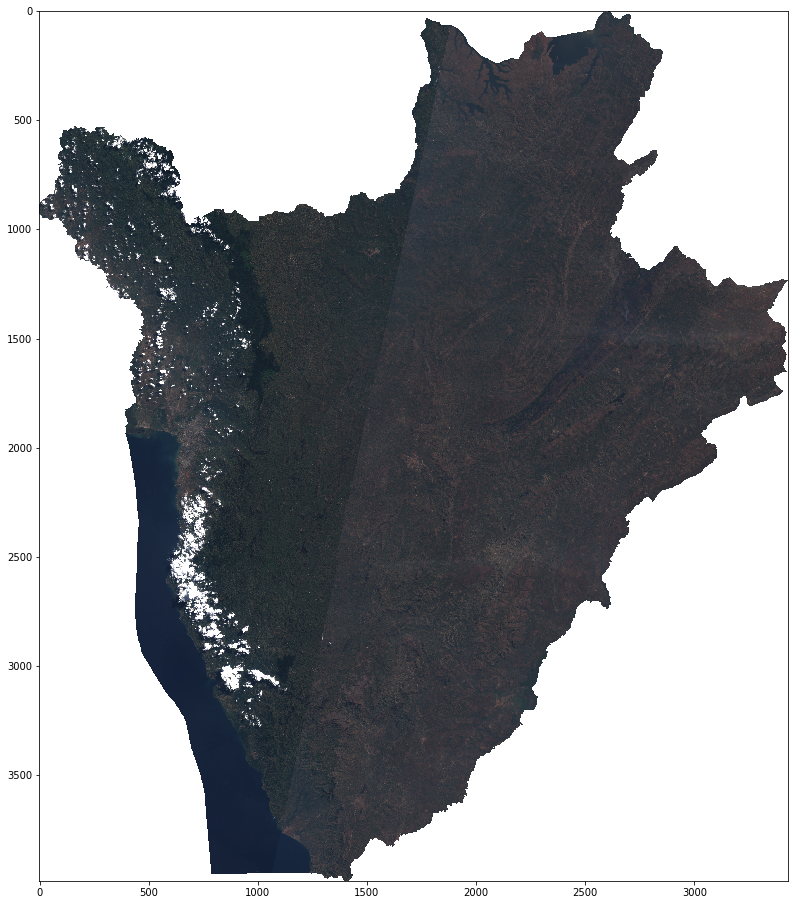

In [37]:
# *************PLOT SINGLE IMAGE ***************

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[16,16])
plt.imshow(arr)

Next Steps:
1. Find and import Black Marble image into a different notebook. Note the year captured.
2. Test techniques on Sattelite and NightLight sample data. 
2. Complete the datasets - Identify all day Landsat 8 images over Burundi for the given Black Marble and output image from the year with less than 10% cloud cover.
3. Output the images, and select a subset that covers the country.